In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np

!pip install -q transformers tensorflow_datasets
from transformers import TFBertModel, BertTokenizer, TFBertForSequenceClassification

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image

In [2]:
# load dataset (text only)

train_folder = '/content/drive/My Drive/Datasets/'

train_filepath = "/content/drive/My Drive/Datasets/train.jsonl"
df_train = pd.read_json(train_filepath, lines=True)

In [3]:
# load test

validation_filepath = "/content/drive/My Drive/Datasets/dev.jsonl"
df_validation = pd.read_json(validation_filepath, lines=True)

In [4]:
# for debugging

df_mini_train = df_train[df_train.id <= 1483]

In [5]:
# set max_length and batch size (recommended for BERT fine-tuning)

max_length = 320
batch_size = 14

In [6]:
# tokenize and encode text for BERT

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def convert_example_to_feature(meme):
  return tokenizer.encode_plus(meme, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                truncation = True
              )

# prepare dataset for the model, of shape {input_ids, token_type_ids, attention_mask, img}
  
def map_example_to_dict(input_ids, attention_masks, token_type_ids, img_arr, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      "image_input": img_arr,
  }, label

def encode_examples(df):

  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  image_list = []
  label_list = []
    
  for index, row in df.iterrows():

    meme = row.text 
    label = int(row.label)
    bert_input = convert_example_to_feature(meme)
    img_loc = row.img
    img_arr = image.img_to_array(image.load_img(train_folder + img_loc, target_size=(299, 299))).astype(np.float32)

    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    image_list.append(img_arr)
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, image_list, label_list)).map(map_example_to_dict)

In [7]:
ds_mini_train_encoded = encode_examples(df_mini_train).batch(batch_size)
#ds_train_encoded = encode_examples(df_train).shuffle(3000).batch(batch_size)
#ds_test_encoded = encode_examples(df_validation).batch(batch_size)

In [10]:
# create concatenated model

# input layers for BERT model

input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_ids', dtype=tf.int32)
token_type_ids = tf.keras.layers.Input(shape=(max_length,), name='token_type_ids', dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(max_length,), name='attention_mask', dtype=tf.int32)

# load BERT model

text_model = TFBertModel.from_pretrained("bert-base-uncased")

# create output of BERT

bert_out = text_model(inputs = {"input_ids": input_ids, "token_type_ids" : token_type_ids, "attention_mask": attention_mask})[0]

# input layer for Inception V3 model

input_tensor = tf.keras.layers.Input(shape=(299,299,3,), name='image_input', dtype=tf.float32)

# create output of Inception V3

model_image = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
image_out = model_image(input_tensor)
inception_out = tf.keras.layers.GlobalAveragePooling2D()(image_out)

# concatenate both outputs

concatenated = tf.keras.layers.Concatenate(axis=1)([bert_out[:,0,:], inception_out])

# connect to fully connected layer

full = tf.keras.layers.Dense(1024, activation='relu', name='full_layer')(concatenated)

# dropout 20% of neurons

dropout = tf.keras.layers.Dropout(0.2)(full)

# classifier layer

out = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(dropout)

# freeze the layers corresponding to the pretrained models

text_model.trainable = False
for layer in model_image.layers:
    layer.trainable = False

# define and compile model

model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask, input_tensor],
                       outputs=out)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# show model variables

model.summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


87916544/87910968 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 320)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 320)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 320)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 299, 299, 3) 0                                            
______________________

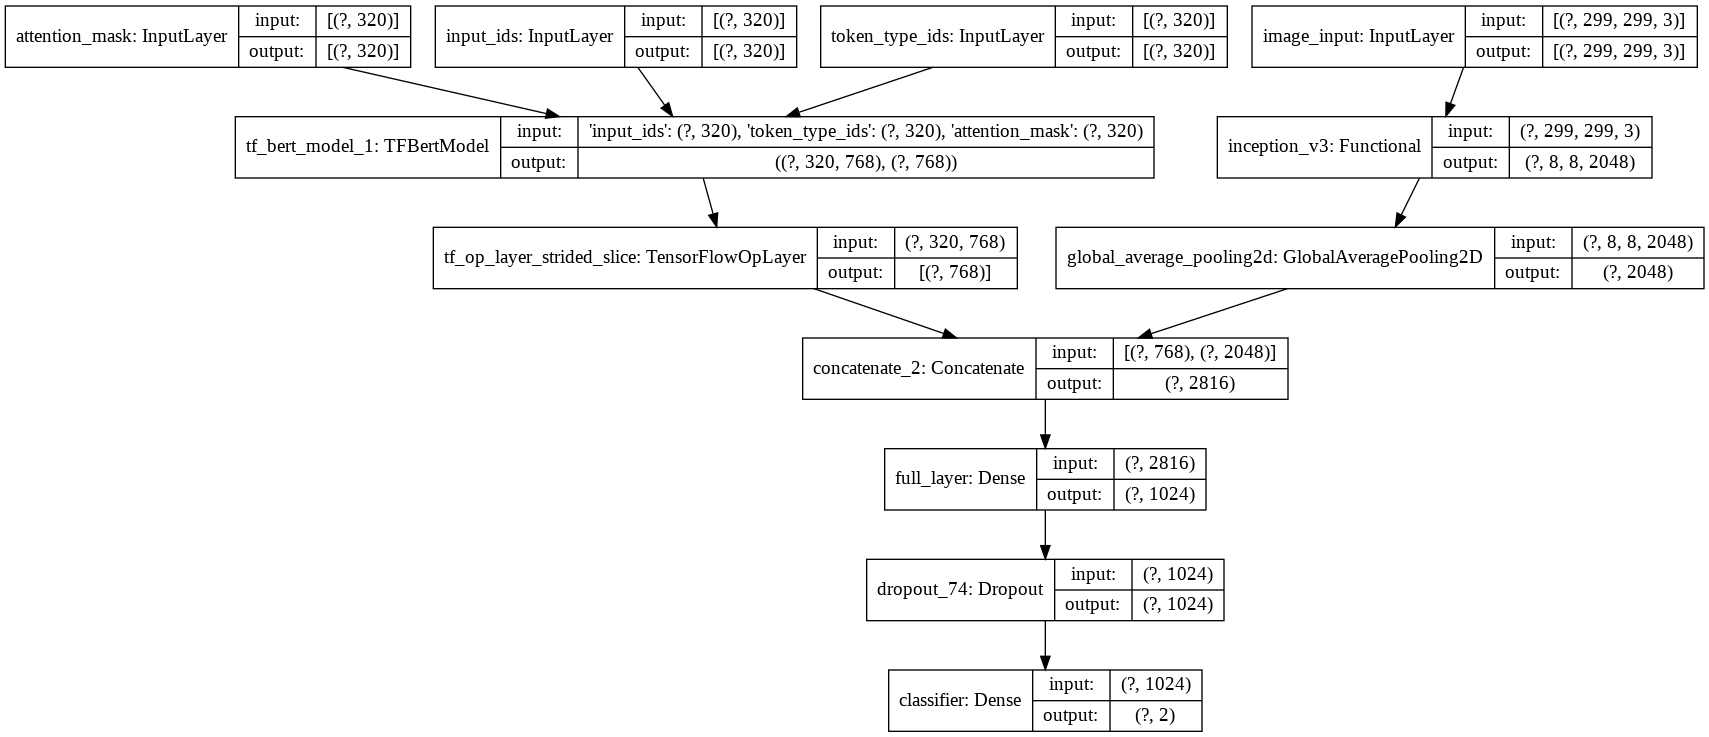

In [11]:
# plot model

tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
epochs = 10
model.fit(ds_mini_train_encoded, epochs=epochs)
#train_history = model.fit(ds_train_encoded, epochs=epochs, validation_data=ds_test_encoded)

Epoch 1/10
3/3 [==============================] - 1s 245ms/step - loss: 0.8478 - accuracy: 0.4286
Epoch 2/10
3/3 [==============================] - 0s 137ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 3/10
3/3 [==============================] - 0s 132ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 4/10
3/3 [==============================] - 0s 131ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 5/10
3/3 [==============================] - 0s 133ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 6/10
3/3 [==============================] - 0s 134ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 7/10
3/3 [==============================] - 0s 134ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 8/10
3/3 [==============================] - 0s 132ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 9/10
3/3 [==============================] - 0s 134ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 10/10
3/3 [==============================] - 0s 131ms/step - loss: 0.6561 - accuracy: 0.6571


In [13]:
# fine-tune the model

# unfreeze the pretrained layers

text_model.trainable = True
for layer in model_image.layers:
    layer.trainable = True

# recompile the model, with a smaller learning rate

learning_rate = 1e-06
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [14]:
epochs = 2
model.fit(ds_mini_train_encoded, epochs=epochs)
#train_history = model.fit(ds_train_encoded, epochs=epochs, validation_data=ds_test_encoded)

Epoch 1/2
3/3 [==============================] - 2s 518ms/step - loss: 0.6561 - accuracy: 0.6571
Epoch 2/2
3/3 [==============================] - 1s 350ms/step - loss: 0.6560 - accuracy: 0.6571
